# Cart Pole TD-AC Solution

![td_ac](../images/lecture_4/td_ac.png)


## Import Env


In [11]:
import gymnasium as gym
from gymnasium.envs.classic_control.cartpole import CartPoleEnv
for k, v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))


CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [12]:
env = gym.make("CartPole-v1")
print("Observation space: ", env.observation_space)
print("Observation shape: ", env.observation_space.shape)
print("Action space: ", env.action_space)


Observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Observation shape:  (4,)
Action space:  Discrete(2)


## Normalizer

In [13]:
import numpy as np


def normalizer(env: gym.Env, state: np.ndarray):
    LOW = np.asarray(env.observation_space.low, dtype=np.float64)
    HIGH = np.asarray(env.observation_space.high, dtype=np.float64)
    normalized_state = np.zeros(state.shape)
    normalized_state = (state-LOW)/(HIGH - LOW)
    normalized_state = normalized_state.astype(np.float32)
    return normalized_state

normalizer(env,env.reset()[0])


array([0.49609885, 0.5       , 0.4773186 , 0.5       ], dtype=float32)

## Actor


In [14]:
import torch
import torch.nn as nn
import torch.distributions as distributions


class Actor(nn.Module):
    def __init__(self, num_observations: int, num_actions: int) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(num_observations, 128)
        self.linear_2 = nn.Linear(128, num_actions)
        self.selu = nn.SELU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        action_prob = self.linear_1(state)
        action_prob = self.selu(action_prob)
        action_prob = self.linear_2(action_prob)
        action_prob = self.softmax(action_prob)
        return action_prob


distributions.Categorical(Actor(env.observation_space.shape[0], env.action_space.n)(
    torch.tensor(env.reset()[0], dtype=torch.float32))).sample()


tensor(1)

## Critic


In [15]:
class Critic(nn.Module):
    def __init__(self, num_observations: int) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(num_observations, 128)
        self.linear_2 = nn.Linear(128, 1)
        self.selu = nn.SELU()

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        state_value = self.linear_1(state)
        state_value = self.selu(state_value)
        state_value = self.linear_2(state_value)
        return state_value


Critic(env.observation_space.shape[0])(
    torch.tensor(env.reset()[0], dtype=torch.float32))


tensor([0.2970], grad_fn=<AddBackward0>)

## Transition and Experience


In [16]:
import random
from collections import deque, namedtuple
from typing import List
Transition = namedtuple(
    "Transition", ["state", "action", "next_state", "reward"])


class Experience:
    def __init__(self, maxlen: int) -> None:
        self.experience = deque([], maxlen)

    def __len__(self) -> int:
        return len(self.experience)

    def sample(self, batch_size: int) -> List:
        return random.sample(self.experience, batch_size)

    def append(self, transition: Transition):
        self.experience.append(transition)


## Decayed Learning Rate


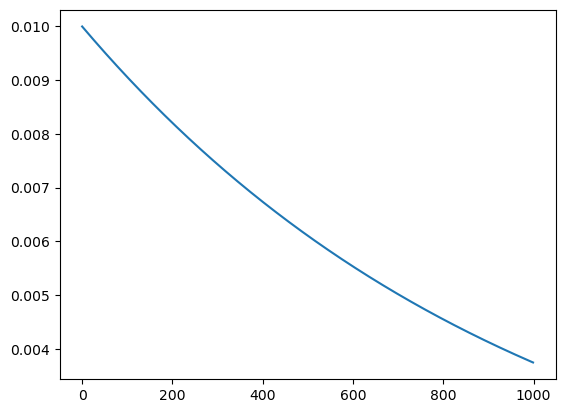

In [17]:
import numpy as np


def get_learning_rate(learning_rate_start: float, learning_rate_end: float, num_episodes: float, step_i: int):
    """return epsilon=epsilon_end+(epsilon_start-epsilon_end)*decay_rate**step_decay"""
    learning_rate = learning_rate_end + \
        (learning_rate_start-learning_rate_end)*np.exp(-1.0*step_i/num_episodes)
    return learning_rate


def plot_learning_rate(epsilon_start: float, epsilon_end: float, num_episode: float):
    import matplotlib.pyplot as plt
    xs = np.arange(num_episode)
    lrs = np.array([get_learning_rate(
        epsilon_start, epsilon_end, num_episode, step) for step in xs])
    plt.plot(xs, lrs)


plot_learning_rate(1e-2, 1e-4, int(1e3))


## Actor-Critic Solution


In [18]:
def update_actor_critic(actor:Actor,critic: Critic, critic_target: Critic, 
                        optimizer_actor: torch.optim.Optimizer, optimizer_critic: torch.optim.Optimizer,
                        experience: Experience, batch_size:int,
                        learning_rate_actor: float, learning_rate_critic: float,
                        discount_factor: float,
                        critic_shift_tau: float,
                        device: str):
    for g in optimizer_actor.param_groups:
        g["lr"]=learning_rate_actor
    for g in optimizer_critic.param_groups:
        g["lr"]=learning_rate_critic
    
    batch=experience.sample(batch_size)
    batch_state,batch_action,batch_next_state,batch_reward=zip(*batch)
    
    # process non-none next_state
    mask_batch_next_state_is_not_none=[next_state is not None for next_state in batch_next_state]
    batch_not_none_next_state=[next_state for next_state in batch_next_state if next_state is not None]
    
    # transfer to tensor
    batch_state=torch.tensor(batch_state,dtype=torch.float32,device=device)
    batch_action=torch.tensor(batch_action,dtype=torch.int64,device=device).reshape((-1,1))
    batch_not_none_next_state=torch.tensor(batch_not_none_next_state,dtype=torch.float32,device=device)
    batch_reward=torch.tensor(batch_reward,dtype=torch.float32,device=device).reshape((-1,1))
    mask_batch_next_state_is_not_none=torch.tensor(mask_batch_next_state_is_not_none,dtype=torch.bool,device=device)
    
    value_state=critic(batch_state)
    # calculate td delta
    value_next_state=torch.zeros(batch_reward.size(),dtype=torch.float32,device=device)
    with torch.no_grad():
        value_next_state[mask_batch_next_state_is_not_none]=critic_target(batch_not_none_next_state)
    td_target=batch_reward+discount_factor*value_next_state
    
    batch_action_log_prob=torch.log(actor(batch_state).gather(-1,batch_action))
    
    loss_critic_fn=nn.MSELoss()
    td_delta=torch.zeros(td_target.size(),dtype=torch.float32,device=device)
    with torch.no_grad():
        td_delta=td_target-value_state
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    loss_actor=-torch.mean(td_delta*batch_action_log_prob)
    loss_actor.backward()
    loss_critic=loss_critic_fn(value_state,td_target)
    loss_critic.backward()
    optimizer_actor.step()
    optimizer_critic.step()
    
    critic_state_dict=critic.state_dict()
    critic_target_state_dict=critic_target.state_dict()
    for key in critic_state_dict:
        critic_target_state_dict[key]=critic_state_dict[key]*critic_shift_tau+critic_target_state_dict[key]*(1-critic_shift_tau)
    critic_target.load_state_dict(critic_target_state_dict)
    

In [19]:
from collections import defaultdict
from typing import Tuple, Dict


def actor_critic(env: gym.Env, num_episodes: int,
                 experience_maxlen: int = 1024, batch_size: int = 128,
                 learning_rate_actor_start: float = 1e-3, learning_rate_actor_end: float = 1e-4,
                 learning_rate_critic_start: float = 1e-3, learning_rate_critic_end: float = 1e-4,
                 discount_factor: float = 0.9,
                 critic_shift_tau: float = 0.05,
                 device: str = "cpu",
                 print_step: int = 100) -> Tuple[Actor, Critic, Dict]:
    actor = Actor(
        env.observation_space.shape[0], env.action_space.n).to(device)
    critic = Critic(env.observation_space.shape[0]).to(device)
    critic_target = Critic(env.observation_space.shape[0]).to(device)
    critic_target.load_state_dict(critic.state_dict())
    # init optimizers for actor and critic
    optimizer_actor = torch.optim.SGD(actor.parameters(),lr=learning_rate_actor_start)
    optimizer_critic = torch.optim.SGD(critic.parameters(),lr=learning_rate_critic_start)
    # recorder
    experience = Experience(experience_maxlen)
    durations_per_episode = defaultdict(float)

    # main train loop
    for episode_i in range(num_episodes):
        # update learning rate first
        learning_rate_actor = get_learning_rate(
            learning_rate_actor_start, learning_rate_actor_end, num_episodes, episode_i)
        learning_rate_critic = get_learning_rate(
            learning_rate_critic_start, learning_rate_critic_end, num_episodes, episode_i)
        # reset env, run the game
        state = env.reset()[0]
        is_terminated = False
        while not is_terminated:
            # normalized_state=normalizer(env,state)
            state_tensor = torch.tensor(
                state, dtype=torch.float32, device=device)
            action_prob = actor(state_tensor)
            action_distribution = distributions.Categorical(action_prob)
            action_tensor = action_distribution.sample()
            action = action_tensor.item()
            next_state, reward, is_terminated, is_truncated, info = env.step(
                action)
            if is_terminated:
                reward = 0.0
                next_state = None
            experience.append(Transition(
                state, action, next_state, reward))
            # update state to next state
            state = next_state
            durations_per_episode[episode_i] += reward

            if len(experience) > batch_size:
                # update actor and critic
                update_actor_critic(actor, critic, critic_target, 
                                    optimizer_actor, optimizer_critic,
                                    experience, batch_size,
                                    learning_rate_actor, learning_rate_critic,
                                    discount_factor, critic_shift_tau,
                                    device)

        if episode_i % print_step == 0:
            print("episode %d, duration %d" %
                  (episode_i, durations_per_episode[episode_i]))

    return actor, critic, durations_per_episode


In [20]:
actor, critic, durations_per_episode = actor_critic(env, num_episodes=1000,
                                                    experience_maxlen=1024, batch_size=128,
                                                    learning_rate_actor_start=1e-3, learning_rate_actor_end=1e-4,
                                                    learning_rate_critic_start=1e-3, learning_rate_critic_end=1e-4,
                                                    discount_factor=0.9,
                                                    critic_shift_tau=0.05,
                                                    device= "cuda" if torch.cuda.is_available() else "cpu", print_step=100)


episode 0, duration 9
episode 100, duration 28
episode 200, duration 211
episode 300, duration 68
episode 400, duration 113
episode 500, duration 114
episode 600, duration 156
episode 700, duration 177
episode 800, duration 164
episode 900, duration 194


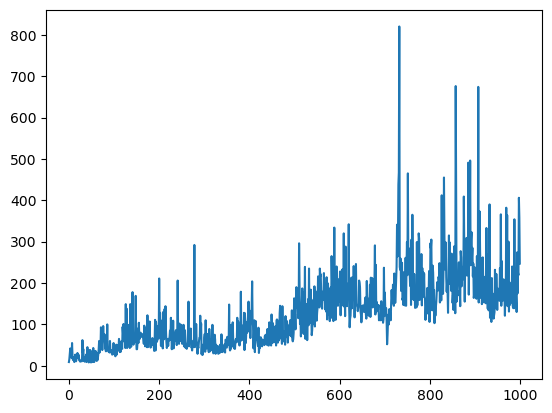

In [21]:
import matplotlib.pyplot as plt
def plot_num_durations_per_episode(num_durations_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(num_durations_per_episode.keys(),num_durations_per_episode.values())
plot_num_durations_per_episode(durations_per_episode)

In [22]:
torch.save(actor.state_dict(),"saves/CartPole-v1-pg-exp-actor.pth")
torch.save(critic.state_dict(),"saves/CartPole-v1-pg-exp-critic.pth")